In [1]:
!pip install -q matplotlib torch FrEIA

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.4 MB/s eta 0:00:00


In [2]:
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
import FrEIA.framework as Ff
import FrEIA.modules as Fm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device", device)

def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 256), nn.LeakyReLU(0.1),
        nn.Linear(256, 256), nn.LeakyReLU(0.1),
        nn.Linear(256, dims_out)
    )

def INN(num_joints=4):
    nodes = [Ff.InputNode(num_joints, name='input')]
    for k in range(10):
        nodes.append(Ff.Node(nodes[-1],
                             Fm.PermuteRandom,
                             {'seed': k},
                             name=f'perm_{k}'))
        nodes.append(Ff.Node(nodes[-1],
                             Fm.GLOWCouplingBlock,
                             {'subnet_constructor': subnet_fc, 'clamp': 1.9},
                             name=f'glow_{k}'))
    nodes.append(Ff.OutputNode(nodes[-1], name='output'))
    return Ff.GraphINN(nodes)

def end_edductor_pos(clampps,theta1,theta2,theta3):
  l1=0.5
  l2=0.5
  l3=1.0
  x_coordinate = l1 * torch.cos(theta1) + l2 * torch.cos(theta2 - theta1) + l3 * torch.cos(theta3 - theta1 - theta2)
  y_coordinate = clampps + l1 * torch.sin(theta1) + l2 * torch.sin(theta2 - theta1) + l3 * torch.sin(theta3 - theta1 - theta2)
  return x_coordinate, y_coordinate

import torch

def end_effector_pos(clampps, theta1, theta2, theta3):
    l1 = 0.5
    l2 = 0.5
    l3 = 1.0
    y = clampps + l1 * torch.sin(theta1) + l2 * torch.sin(theta2 - theta1) + l3 * torch.sin(theta3 - theta1 - theta2)
    x = l1 * torch.cos(theta1) + l2 * torch.cos(theta2 - theta1) + l3 * torch.cos(theta3 - theta1 - theta2)
    return x, y

def train_set(n_samples=1000):
    sigma1 = 0.25
    sigma_others = 0.5
    x1 = torch.randn(n_samples) * sigma1
    x2 = torch.randn(n_samples) * sigma_others
    x3 = torch.randn(n_samples) * sigma_others
    x4 = torch.randn(n_samples) * sigma_others

    y1, y2 = end_effector_pos(x1, x2, x3, x4)

    x = torch.stack([x1, x2, x3, x4], dim=1)
    y = torch.stack([y1, y2], dim=1)
    return x, y

Using device cuda


In [5]:
def train_model(model, x_train, y_train, n_epochs=1, batch_size=512, lr=1e-4, weight_fk=10.0, weight_latent=1.0, weight_rev=5.0):
    print("Starting INN training...")
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    latent_dim = 2  # Number of latent variables
    start_time = time.time()

    for epoch in range(n_epochs):
        print('Current epoch',epoch)
        model.train()
        epoch_loss_f = 0.0
        epoch_loss_z = 0.0
        epoch_loss_rev = 0.0
        epoch_loss_total = 0.0

        n_batches = max(1, len(x_train) // batch_size)

        for i in tqdm(range(n_batches)):
            optimizer.zero_grad()

            # Get batch
            start = i * batch_size
            end = min(len(x_train), (i + 1) * batch_size)
            x_batch = x_train[start:end].to(device)
            y_batch_gt = y_train[start:end].to(device)

            # --- Forward Pass ---
            out_inn_tensor, _ = model(x_batch)
            y_pred = out_inn_tensor[:, :2]
            z_pred = out_inn_tensor[:, 2:]

            loss_f = mse_loss(y_pred, y_batch_gt)
            loss_z = torch.mean(z_pred ** 2) / 2.0

            # --- Reverse Pass ---
            z_rev_sample = torch.randn(len(x_batch), latent_dim, device=device)
            rev_input = torch.cat((y_batch_gt, z_rev_sample), dim=1)
            x_rev_pred_tensor, _ = model(rev_input, rev=True)

            y1, y2 = end_effector_pos(x_rev_pred_tensor[:, 0],
                                      x_rev_pred_tensor[:, 1],
                                      x_rev_pred_tensor[:, 2],
                                      x_rev_pred_tensor[:, 3])
            y_rev_pred = torch.stack([y1, y2], dim=1)

            loss_rev = mse_loss(y_rev_pred, y_batch_gt)

            # Total loss
            total_loss = weight_fk * loss_f + weight_latent * loss_z + weight_rev * loss_rev
            total_loss.backward()
            optimizer.step()

            # Accumulate losses
            epoch_loss_f += loss_f.item()
            epoch_loss_z += loss_z.item()
            epoch_loss_rev += loss_rev.item()
            epoch_loss_total += total_loss.item()

            if (i + 1) % max(1, n_batches // 10) == 0 or i == n_batches - 1:
                print(f" Batch {i+1}/{n_batches} - Loss: {total_loss.item():.4f} "
                      f"(Fk:{loss_f.item():.4f}, Z:{loss_z.item():.4f}, Rev:{loss_rev.item():.4f})", end='\r')

        # Log epoch summary
        avg_epoch_loss = epoch_loss_total / n_batches
        avg_epoch_loss_f = epoch_loss_f / n_batches
        avg_epoch_loss_z = epoch_loss_z / n_batches
        avg_epoch_loss_rev = epoch_loss_rev / n_batches
        elapsed_time = time.time() - start_time

        print(f"\nEpoch {epoch+1}/{n_epochs} - Time: {elapsed_time:.1f}s " f"- Train Loss: {avg_epoch_loss:.4f} (F:{avg_epoch_loss_f:.4f}, Z:{avg_epoch_loss_z:.4f}, R:{avg_epoch_loss_rev:.4f})")

    print("Training finished.")

In [6]:
model = INN()
model.to(device) # Move the model to the appropriate device
x_train, y_train = train_set(1000)
x_train, y_train = x_train.to(device), y_train.to(device)
train_model(model, x_train, y_train, n_epochs=10, batch_size=512, lr=1e-4, weight_fk=10.0, weight_latent=1.0, weight_rev=5.0)
# save model
torch.save(model.state_dict(), 'robot_arm.pth')

# load model for testing
model = INN()
model.load_state_dict(torch.load('robot_arm.pth'))
model.to(device) # Move the loaded model to the appropriate device
model.eval()

Starting INN training...
Current epoch 0


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


 Batch 1/1 - Loss: 30.1654 (Fk:1.5503, Z:0.1084, Rev:2.9108)
Epoch 1/10 - Time: 0.9s - Train Loss: 30.1654 (F:1.5503, Z:0.1084, R:2.9108)
Current epoch 1


100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


 Batch 1/1 - Loss: 22.7371 (Fk:1.2405, Z:0.1105, Rev:2.0444)
Epoch 2/10 - Time: 0.9s - Train Loss: 22.7371 (F:1.2405, Z:0.1105, R:2.0444)
Current epoch 2


100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


 Batch 1/1 - Loss: 18.7019 (Fk:0.9810, Z:0.1175, Rev:1.7548)
Epoch 3/10 - Time: 1.0s - Train Loss: 18.7019 (F:0.9810, Z:0.1175, R:1.7548)
Current epoch 3


100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


 Batch 1/1 - Loss: 15.7638 (Fk:0.7597, Z:0.1382, Rev:1.6057)
Epoch 4/10 - Time: 1.1s - Train Loss: 15.7638 (F:0.7597, Z:0.1382, R:1.6057)
Current epoch 4


100%|██████████| 1/1 [00:00<00:00, 17.31it/s]


 Batch 1/1 - Loss: 13.8767 (Fk:0.5777, Z:0.1692, Rev:1.5861)
Epoch 5/10 - Time: 1.1s - Train Loss: 13.8767 (F:0.5777, Z:0.1692, R:1.5861)
Current epoch 5


100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


 Batch 1/1 - Loss: 12.4899 (Fk:0.4530, Z:0.2107, Rev:1.5499)
Epoch 6/10 - Time: 1.2s - Train Loss: 12.4899 (F:0.4530, Z:0.2107, R:1.5499)
Current epoch 6


100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


 Batch 1/1 - Loss: 12.2290 (Fk:0.4113, Z:0.2518, Rev:1.5727)
Epoch 7/10 - Time: 1.2s - Train Loss: 12.2290 (F:0.4113, Z:0.2518, R:1.5727)
Current epoch 7


100%|██████████| 1/1 [00:00<00:00, 19.29it/s]


 Batch 1/1 - Loss: 12.7152 (Fk:0.4412, Z:0.2689, Rev:1.6068)
Epoch 8/10 - Time: 1.3s - Train Loss: 12.7152 (F:0.4412, Z:0.2689, R:1.6068)
Current epoch 8


100%|██████████| 1/1 [00:00<00:00, 19.20it/s]


 Batch 1/1 - Loss: 12.3104 (Fk:0.4611, Z:0.2553, Rev:1.4889)
Epoch 9/10 - Time: 1.4s - Train Loss: 12.3104 (F:0.4611, Z:0.2553, R:1.4889)
Current epoch 9


100%|██████████| 1/1 [00:00<00:00, 18.74it/s]

 Batch 1/1 - Loss: 323.2849 (Fk:0.4512, Z:0.2284, Rev:63.7089)
Epoch 10/10 - Time: 1.4s - Train Loss: 323.2849 (F:0.4512, Z:0.2284, R:63.7089)
Training finished.


GraphINN(
  (module_list): ModuleList(
    (0): PermuteRandom()
    (1): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=256, out_features=4, bias=True)
      )
      (subnet2): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=256, out_features=4, bias=True)
      )
    )
    (2): PermuteRandom()
    (3): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): 

In [7]:
def infer_x(model , x_test):
  with torch.no_grad():
    x_test = x_test.to(device)
    out_inn_tensor, _ = model(x_test)
    y_pred = out_inn_tensor[:, :2]
    z_pred = out_inn_tensor[:, 2:]
    return y_pred, z_pred

# Example usage

x_test = torch.randn(1, 4)
y_pred, z_pred = infer_x(model, x_test)
print("y_pred:", y_pred)
print("z_pred:", z_pred)

y_pred: tensor([[ 0.8257, -0.5086]], device='cuda:0')
z_pred: tensor([[ 0.7319, -0.0539]], device='cuda:0')


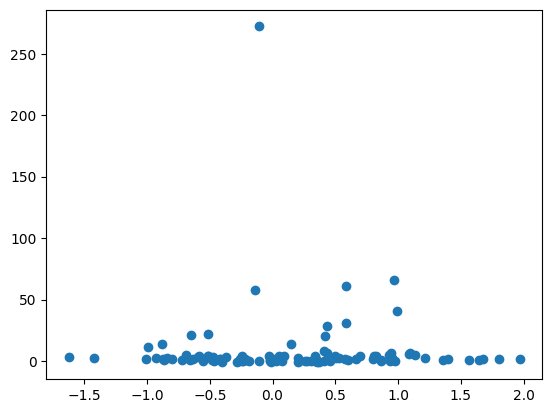

In [11]:
import torch

def infer_y(model, y_test, n_samples=100):
    model.eval()
    device = next(model.parameters()).device

    y_test = y_test.to(device)
    if y_test.dim() == 1:
        y_test = y_test.unsqueeze(0)
    elif y_test.dim() != 2 or y_test.shape[1] != 2:
        raise ValueError(f"y_test should have shape [batch_size, 2] or [1, 2], but got {y_test.shape}")

    batch_size = y_test.shape[0]
    y_dim = y_test.shape[1]
    x_dim = model.dims_in[0][0]
    latent_dim = x_dim - y_dim

    if latent_dim <= 0:
        raise ValueError(f"Calculated latent dimension ({latent_dim}) is not positive. "
                         f"Check model input dimension ({x_dim}) and y_test dimension ({y_dim}).")

    z_samples = torch.randn(batch_size, n_samples, latent_dim, device=device)
    y_test_expanded = y_test.unsqueeze(1).expand(-1, n_samples, -1)
    rev_input = torch.cat((y_test_expanded, z_samples), dim=2)
    total_samples = batch_size * n_samples
    rev_input_flat = rev_input.view(total_samples, x_dim)

    with torch.no_grad():
        x_pred_flat, _ = model(rev_input_flat, rev=True)

    x_pred = x_pred_flat.view(batch_size, n_samples, x_dim)

    if batch_size == 1:
        x_pred = x_pred.squeeze(0)

    return x_pred

# Example usage
y_test = torch.randn(1, 2)
x_pred = infer_y(model, y_test)
points = []
for config in x_pred:
  x_cor,y_cor = end_effector_pos(config[0], config[1], config[2], config[3])
  points.append([x_cor,y_cor])

# cuda to cpu
points = [[point[0].cpu().numpy(), point[1].cpu().numpy()] for point in points]

# plot the points
plt.scatter([point[0] for point in points], [point[1] for point in points])
plt.show()